#                   EMG WORD LEVEL MODEL DEVELOPMENT

In [1]:
# import necessary modules
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import tqdm
import pprint
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100


import librosa
import librosa.display

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras


Using TensorFlow backend.


In [2]:
# necessary definitions

MAIN_DIR = "/home/deadpool/Kaggle Projects/EMG Tanja Ma'am/"
os.chdir(MAIN_DIR)

AUDIBLE = os.path.join("TOP_WORDS","audible")
WHISPERED = os.path.join("TOP_WORDS","whispered")
SILENT = os.path.join("TOP_WORDS","silent")

MODEL_PATH = ""

MODES = [AUDIBLE, WHISPERED, SILENT]

SR_AUDIO = 16000 # in Hz
SR_EMG = 600 # in Hz

FRAME_SIZE = 27 # in milliseconds
FRAME_SHIFT = 10 # in milliseconds

FRAME_SAMPLES = int((FRAME_SIZE/1000)*SR_EMG)
PER_FRAME_SAMPLES = int((FRAME_SHIFT/1000)*SR_EMG)

print("Samples in a frame: ",FRAME_SAMPLES)
print("Samples shift per frame: ",PER_FRAME_SAMPLES)


# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(MAIN_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# a function to save trained models as pickle object
def save_model(name,model,extension=".pickle"):
    path = os.path.join(MODEL_PATH,name+extension)
    print("Saving Model : ",name)
    file = open(path,"wb")
    pickle.dump(model,file)
    file.close()


Samples in a frame:  16
Samples shift per frame:  6


## IMPORTING DATASET

In [3]:
top_10_words = ["THE","A","TO","OF","IN","ARE","AND","IS","THEY","THAT"]
top_20_words = top_10_words + ["THIS","AN","HAS","HE","I","ON","WERE","IT","WE","YOU"]

# for top 10 words
audio_file = "Top10_Audio.pickle"
emg_file = "Top10_EMG.pickle"

# for top 20 words
# audio_file = "Top20_Audio.pickle"
# emg_file = "Top20_EMG.pickle"

# AUDIBLE MODE FILES
audible_audio = pickle.load(open(os.path.join(AUDIBLE,audio_file),"rb"))
audible_emg = pickle.load(open(os.path.join(AUDIBLE,emg_file),"rb"))

# WHISPERED MODE FILES
whispered_audio = pickle.load(open(os.path.join(WHISPERED,audio_file),"rb"))
whispered_emg = pickle.load(open(os.path.join(WHISPERED,emg_file),"rb"))

# SILENT MODE FILES
silent_audio = pickle.load(open(os.path.join(SILENT,audio_file),"rb"))
silent_emg = pickle.load(open(os.path.join(SILENT,emg_file),"rb"))

LABELS = list(audible_audio.keys())
LABELS.sort()
print("LABELS: ",LABELS)

LABELS:  ['A', 'AND', 'ARE', 'IN', 'IS', 'OF', 'THAT', 'THE', 'THEY', 'TO']


### Parsing Dataset into Lists

In [4]:
X_audible_emg = []
Y_audible_emg = []

X_whispered_emg = []
Y_whispered_emg = []

X_silent_emg = []
Y_silent_emg = []

for keys in list(audible_emg.keys()):
    X_audible_emg.extend(audible_emg[keys])
    Y_audible_emg.extend([keys] * len(audible_emg[keys]))
    
    X_whispered_emg.extend(whispered_emg[keys])
    Y_whispered_emg.extend([keys] * len(whispered_emg[keys]))

    X_silent_emg.extend(silent_emg[keys])
    Y_silent_emg.extend([keys] * len(silent_emg[keys]))
        

# first convert ADC values to Voltages (0.033 uV)

X_audible_emg = np.array(X_audible_emg) * 0.033
Y_audible_emg = np.array(Y_audible_emg)

X_whispered_emg = np.array(X_whispered_emg) * 0.033
Y_whispered_emg = np.array(Y_whispered_emg)

X_silent_emg = np.array(X_silent_emg) * 0.033
Y_silent_emg = np.array(Y_silent_emg)
        
        
print("AUDIO MODE FILES")
print("X :",(X_audible_emg.shape))
print("Y :",(Y_audible_emg.shape))

print("WHISPERED MODE FILES")
print("X :",(X_whispered_emg.shape))
print("Y :",(Y_whispered_emg.shape))

print("SILENT MODE FILES")
print("X :",(X_silent_emg.shape))
print("Y :",(Y_silent_emg.shape))


AUDIO MODE FILES
X : (2142, 6)
Y : (2142,)
WHISPERED MODE FILES
X : (563, 6)
Y : (563,)
SILENT MODE FILES
X : (561, 6)
Y : (561,)


## VISUALIZING DATASET

### Play the LABEL Words 

In [5]:
from sounddevice import play
from time import sleep

for keys in list(audible_audio.keys()):
    play(audible_audio[keys][20],SR_AUDIO)
    print("Playing :", keys)
    sleep(1)

Playing : THE
Playing : A
Playing : TO
Playing : OF
Playing : IN
Playing : ARE
Playing : AND
Playing : IS
Playing : THEY
Playing : THAT


### Verify the Audio and the EMG samples are synchronized 

In [6]:
print("Length of audio file: {} seconds".format(len(audible_audio["THAT"][0])/SR_AUDIO))
print("Length of emg file: {} seconds".format(len((audible_emg["THAT"][0])[0])/SR_EMG))

Length of audio file: 0.19 seconds
Length of emg file: 0.19 seconds


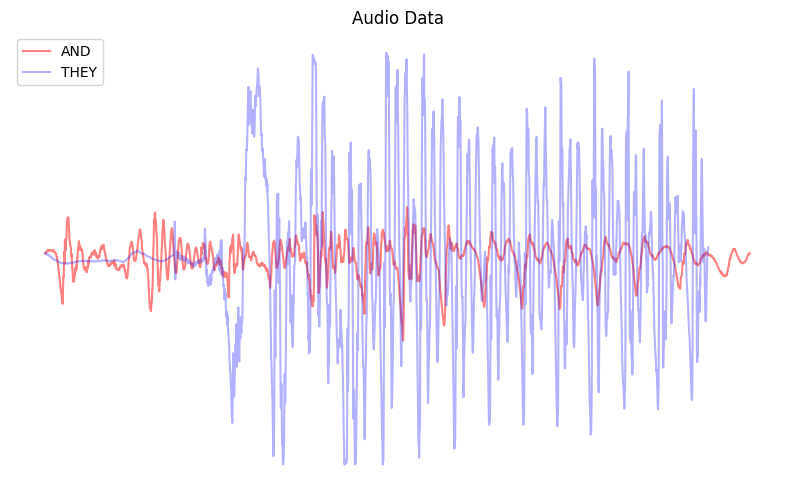

In [7]:
plt.title("Audio Data")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.plot(audible_audio["AND"][20],"r",alpha=0.5)
plt.plot(audible_audio["THEY"][20],"b",alpha=0.3)
plt.legend(["AND","THEY"],loc="upper left")
plt.axis("off")
plt.show()

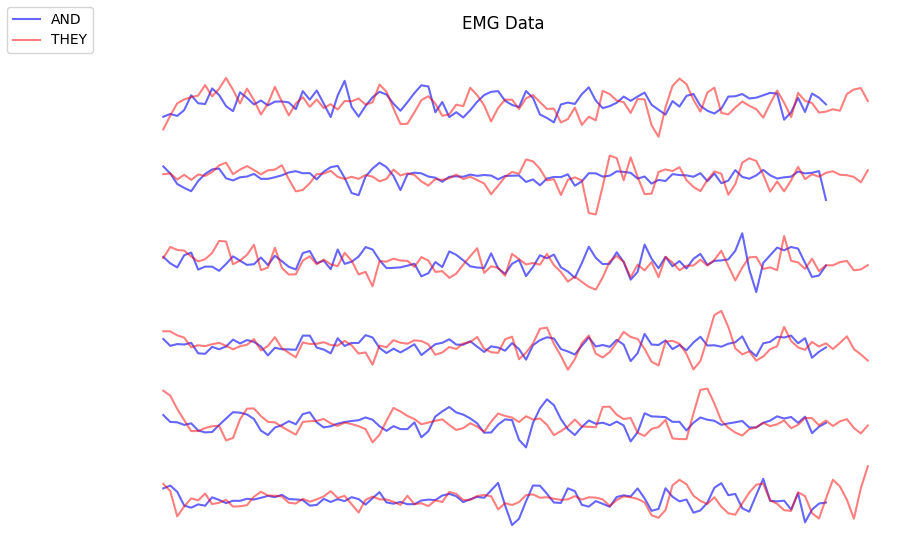

In [8]:
fig,axes = plt.subplots(nrows=6,ncols=1)
fig.suptitle('EMG Data')
for ax,channel in zip(axes.flat,range(6)):
    ax.plot((audible_emg["THEY"][20])[channel],"b",alpha=0.6)
    ax.plot((audible_emg["AND"][20])[channel],"r",alpha=0.5)
    ax.axis("off")

fig.legend(["AND","THEY"],loc="upper left")
plt.show()

### Check Distribution of Data

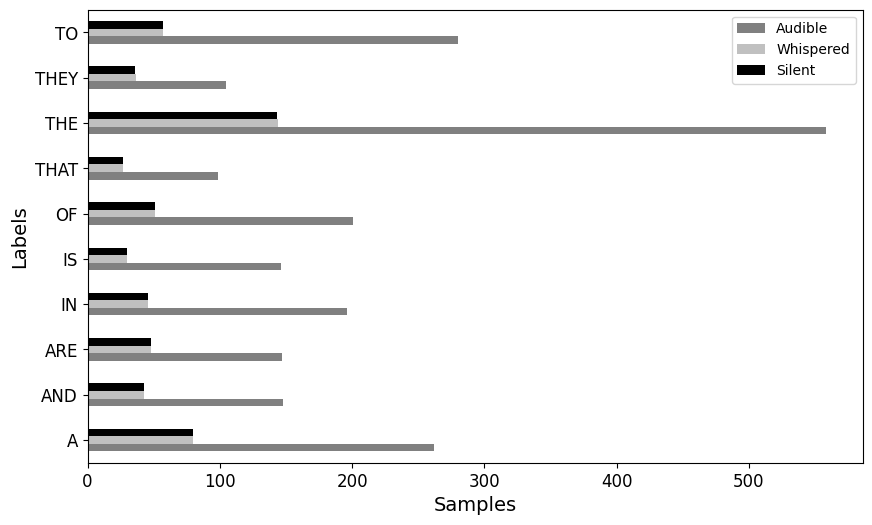

In [9]:
labels = pd.DataFrame({"Audible":(pd.Series(Y_audible_emg)).value_counts(),"Whispered":(pd.Series(Y_whispered_emg)).value_counts(),"Silent":(pd.Series(Y_silent_emg)).value_counts()})
labels.plot(kind="barh",rot=0,color={"black","gray","silver"})
plt.xlabel("Samples")
plt.ylabel("Labels")
plt.show()
# save_fig("Data Distribution")

## PREPROCESSING DATA

### Analysing Data

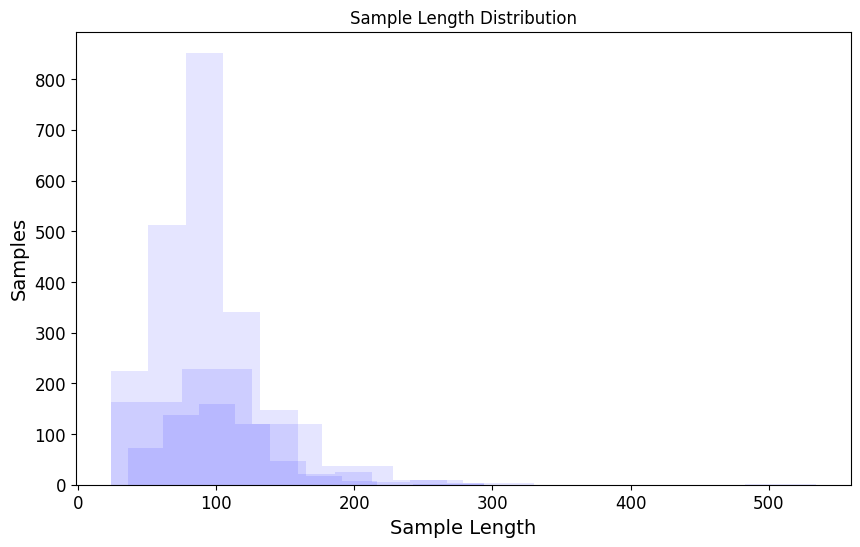

In [10]:
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_audible_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_whispered_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_silent_emg],color="blue",alpha=0.1)
plt.show()

In [11]:
perc = 95
length_95_perc = []
length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_audible_emg], perc)))]
print(f"The {perc}% of the Audible data has length lower or equal to {length_95_perc[0]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_whispered_emg], perc)))]
print(f"The {perc}% of the Whispered data has length lower or equal to {length_95_perc[1]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_silent_emg], perc)))]
print(f"The {perc}% of the Silent data has length lower or equal to {length_95_perc[2]}.")

The 95% of the Audible data has length lower or equal to 144.
The 95% of the Whispered data has length lower or equal to 162.
The 95% of the Silent data has length lower or equal to 198.


In [12]:
# Trimming the data

for x in range(len(X_audible_emg)):
    for channel in range(6):
        X_audible_emg[x][channel] = X_audible_emg[x][channel][:length_95_perc[0]]
        
for x in range(len(X_whispered_emg)):
    for channel in range(6):        
        X_whispered_emg[x][channel] = X_whispered_emg[x][channel][:length_95_perc[1]] 
        
for x in range(len(X_silent_emg)):
    for channel in range(6):        
        X_silent_emg[x][channel] = X_silent_emg[x][channel][:length_95_perc[2]] 


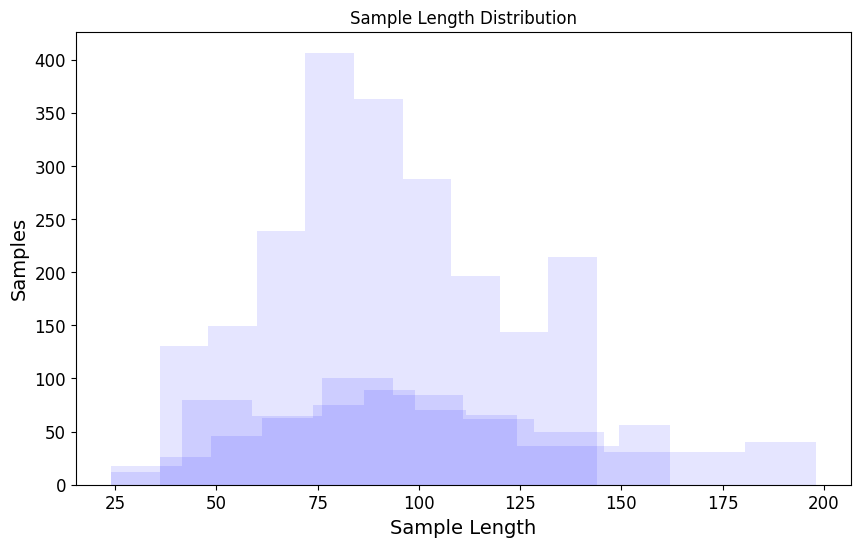

In [13]:
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_audible_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_whispered_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_silent_emg],color="blue",alpha=0.1)
plt.show()

### Scaling the data

In [14]:
# scaling the data (does channel wise mean calculation)

# saves stats for later use in model implementation
channel_mean = []
channel_std = []

from scipy.stats import zscore

for x in range(len(X_audible_emg)):
    for channel in range(6):
        X_audible_emg[x][channel] = zscore(X_audible_emg[x][channel])
        
for x in range(len(X_whispered_emg)):
    for channel in range(6):        
        X_whispered_emg[x][channel] = zscore(X_whispered_emg[x][channel]) 
        
for x in range(len(X_silent_emg)):
    for channel in range(6):        
        X_silent_emg[x][channel] = zscore(X_silent_emg[x][channel])

### Zero Padding the data

In [15]:

for x in range(len(X_audible_emg)):
    for channel in range(6):
        X_audible_emg[x][channel] = np.pad(X_audible_emg[x][channel],(0,length_95_perc[0]-len(X_audible_emg[x][channel])),constant_values=(0.0,0.0))
        
for x in range(len(X_whispered_emg)):
    for channel in range(6):        
        X_whispered_emg[x][channel] = np.pad(X_whispered_emg[x][channel],(0,length_95_perc[1]-len(X_whispered_emg[x][channel])),constant_values=(0.0,0.0))
        
for x in range(len(X_silent_emg)):
    for channel in range(6):        
        X_silent_emg[x][channel] = np.pad(X_silent_emg[x][channel],(0,length_95_perc[2]-len(X_silent_emg[x][channel])),constant_values=(0.0,0.0))
        

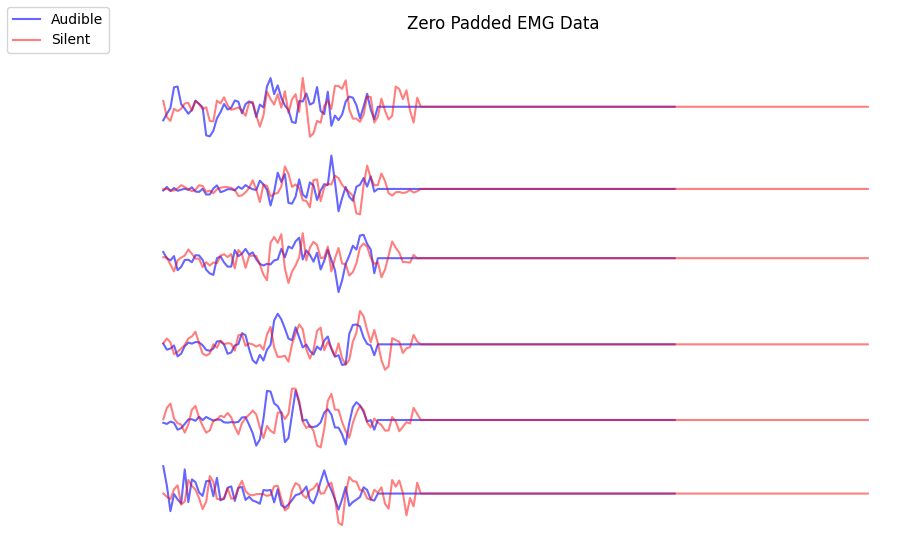

In [16]:
fig,axes = plt.subplots(nrows=6,ncols=1)
fig.suptitle('Zero Padded EMG Data')
for ax,channel in zip(axes.flat,range(6)):
    ax.plot((X_audible_emg[0])[channel],"b",alpha=0.6)
    ax.plot((X_silent_emg[0])[channel],"r",alpha=0.5)
    ax.axis("off")

fig.legend(["Audible","Silent"],loc="upper left")
plt.show()

## FEATURE EXTRACTION

### Defining Feature Class

In [33]:
class EMG(object):
    """
    preprocessing and feature extraction class for EMG data
    X = List of all instances of input data
    x = an instance of the input data 
    Y = List of all instances of input labels
    y = an instance of the input label
    
    average length of a word utterance: ( 600ms(100 wpm) + 480ms (130 wpm) + 360ms (160 wpm) ) / 3 =  480ms
    """
    
    def __init__(self, SR,FRAME_SIZE,FRAME_SHIFT,MODE,DOMAIN="time",DIMENSION=200):
        """Set the variables """
        self.SR = SR
        self.FRAME_SIZE = FRAME_SIZE
        self.FRAME_SHIFT = FRAME_SHIFT
        self.MODE = MODE
        self.DOMAIN = DOMAIN
        self.DIMENSION = DIMENSION # keeping 95% of the variance in data
        self.pickle_name = "X_"+MODE+"(features-"+ DOMAIN +").pickle"
            
        
    def reduce_dimension(self,X,type="PCA"): 
        """
        Reduce the dimension of feature space
        "PCA": Principal Component Analysis
        "ICA": Independent Component Analysis
        """
        feature_len=self.DIMENSION
        if type=="PCA":
            pca = PCA(n_components=feature_len)
            temp_X = pca.fit_transform(X)
#             percentage_var_explained = pca.explained_variance_ratio_  
#             cum_var_explained=np.cumsum(percentage_var_explained)
#             plt.grid() 
#             plt.title("PCA Variance Graph")
#             plt.xlabel('Components') 
#             plt.ylabel('Cumulative Variance') 
#             plt.plot(cum_var_explained)
# #             save_fig("cum_var_whisper")
#             plt.show()


        elif type=="ICA":
            ica = FastICA(n_components=feature_len)
            temp_X = ica.fit_transform(X)
       
        print("New Dimension of Data: ",temp_X.shape)
        return temp_X
    
    
    def encode_labels(self,Y):
        """Encodes the labels"""
        encoder = LabelEncoder()
        return encoder.fit_transform(Y)


    def DNPA(self,seg):
        """Double Nine Point Average"""
        w = []
        for i in range(len(seg)):
            a = i - 4
            b = i + 4
            a = a if a>=0 else 0
            b = b if b<len(seg) else len(seg)
            w.append(int(np.sum(seg[a:b])/9))

        v = []
        for i in range(len(seg)):
            a = i - 4
            b = i + 4
            a = a if a>=0 else 0
            b = b if b<len(seg) else len(seg)
            v.append(int(np.sum(w[a:b])/9))

        return v

    
    def ZCR(self,seg):
        """Zero Crossing Rate"""
        pos = seg>0
        npos = ~pos
        return len(((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0])

    
    def HFS(self,seg):
        """High frequency signals"""
        return np.subtract(seg,self.DNPA(seg))

    
    def RHFS(self,seg):
        """Rectified High frequency signals"""
        return abs(self.HFS(seg))

    
    def FBP(self,seg):
        """Frame Based Power"""
        return np.sum(np.power(seg,2))

    
    def feature(self,seg):
        """ 
        "time": Features in time domain
        "freq": Features in frequency domain
        "all": Features in both domain
        """
        type=self.DOMAIN
        if type == "time":
            return np.hstack((self.DNPA(seg),self.RHFS(seg),self.HFS(seg),self.ZCR(seg),self.FBP(seg)))
        elif type == "freq":
            return self.MFCC(seg)
        elif type == "all":
            return np.hstack(self.feature(seg,"time"),self.feature(seg,"freq"))

    
    def MFCC(self,seg):
        """Mel Frequency Cepstral Coefficients"""
        mfcc = librosa.feature.mfcc(y=seg,sr=self.SR,n_mfcc=10)
        return np.mean(mfcc.T,axis=0)

    
    def STFT(self,seg):
        """Short Time Fourier Transform"""
        stft = librosa.feature.chroma_stft(y=seg,sr=self.SR,n_fft=20)
#         return np.mean(stft.T,axis=0)
        return stft

    
    def segment(self,x):
        """Segmenting the data into frames and sliding them according to the frame shift"""
        f = []
        for channel in range(6):
            for i in range(len(x[0])):
                a = i*self.FRAME_SHIFT
                b = a + self.FRAME_SIZE
                if(b>len(x[0])):
                    break
                seg = x[channel][a:b]
                f.extend(self.feature(seg))
        return f

    
    def fit(self,X,Y):
        """Extract Features and return the data with reduced feature space with encoded labels"""
        if(self.pickle_name in os.listdir() ):
            print("Fetching Pickle file: ",self.pickle_name)
            temp_X = pickle.load(open(self.pickle_name,"rb"))
        else:
            temp_X = []
            for x,count in zip(X, tqdm.tqdm(range(len(X)),ncols=100,desc="Extracting Features("+self.MODE+")" ) ):
                temp_X.append(self.segment(x))

            # save all extracted features to a pickle file
            print("Saving features as: ",self.pickle_name)
            pickle.dump(temp_X,open(self.pickle_name,"wb"))
        temp_X = np.array(temp_X)
        print(len(temp_X))
        print(len(Y))
        print(temp_X.shape)
        return self.reduce_dimension(temp_X),self.encode_labels(Y)
#         return temp_X,self.encode_labels(Y)


    def fit_transform(self,X,Y):
        return self.fit(X,Y)


### Temporal Features

In [18]:
audible_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="audible")

X_audible, Y_audible = audible_EMG.fit_transform(X_audible_emg,Y_audible_emg)

Fetching Pickle file:  X_audible(features-time).pickle
2142
2142
(2142, 6600)
New Dimension of Data:  (2142, 200)


In [19]:
whisper_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="whispered")

X_whisper, Y_whisper = whisper_EMG.fit_transform(X_whispered_emg,Y_whispered_emg)

Fetching Pickle file:  X_whispered(features-time).pickle
563
563
(563, 7500)
New Dimension of Data:  (563, 200)


In [20]:
silent_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="silent")

X_silent, Y_silent = silent_EMG.fit_transform(X_silent_emg,Y_silent_emg)

Fetching Pickle file:  X_silent(features-time).pickle
561
561
(561, 9300)
New Dimension of Data:  (561, 200)


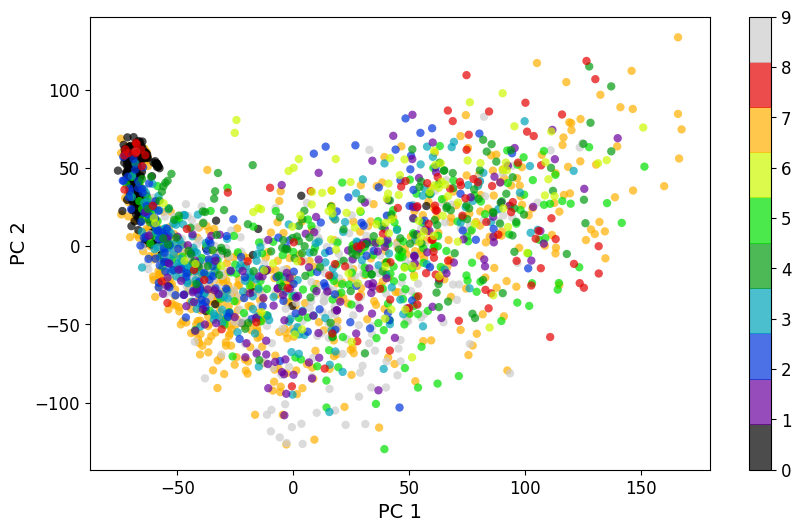

In [21]:
projected = X_audible
plt.scatter(projected[:, 0], projected[:, 1],c=Y_audible, edgecolor='none', alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar()
# save_fig("ICA_2D")
plt.show()

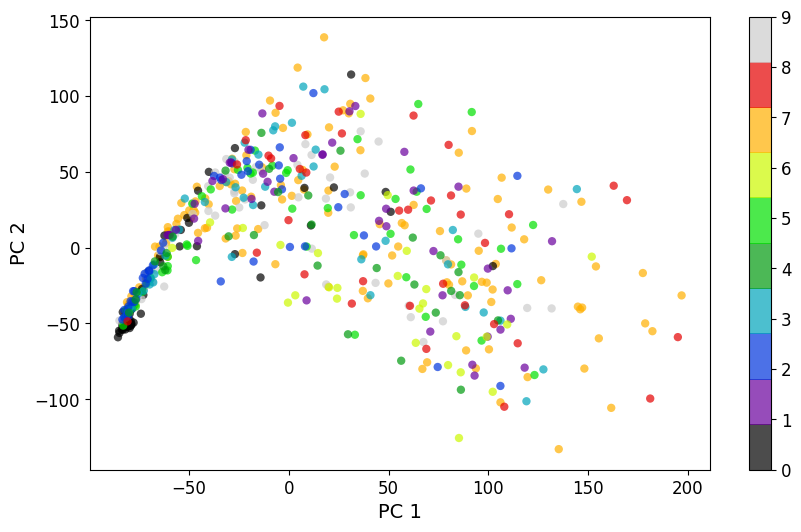

In [22]:
projected = X_silent
plt.scatter(projected[:, 0], projected[:, 1],c=Y_silent, edgecolor='none', alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar()
# save_fig("ICA_2D")
plt.show()

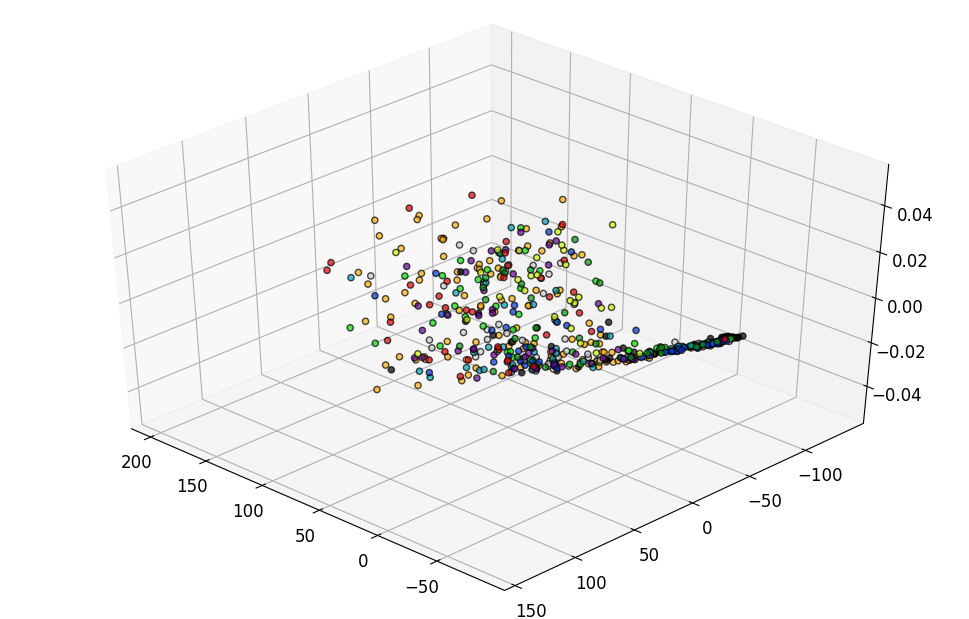

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=134)
ax.scatter(projected[:, 0], projected[:, 1],
            c=Y_silent, edgecolor='k', alpha=0.7,
            cmap=plt.cm.get_cmap("nipy_spectral", 10))

# save_fig("3Dpca")
plt.show()

Fetching Pickle file:  X_silent(features-time).pickle
561
561
(561, 9300)


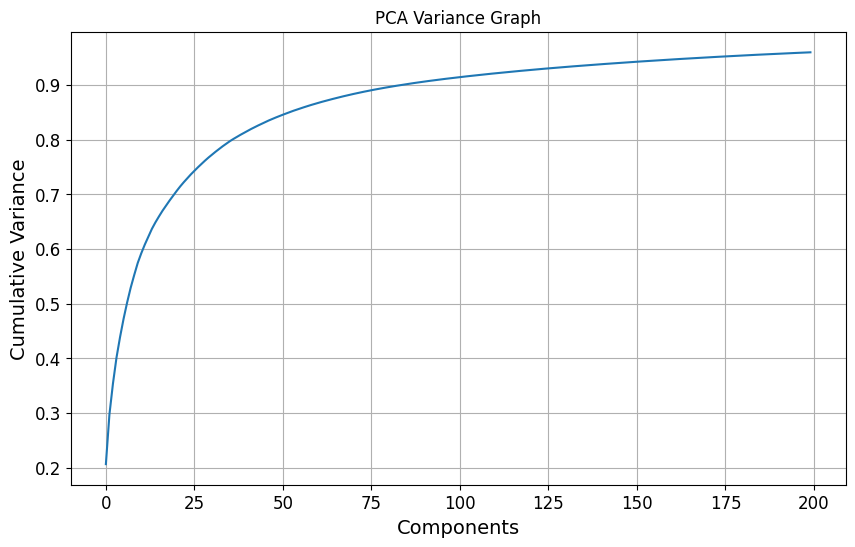

New Dimension of Data:  (561, 200)


In [26]:
silent_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="silent")

X_silent, Y_silent = silent_EMG.fit_transform(X_silent_emg,Y_silent_emg)

### Spectral Features

In [34]:
audible_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="audible",DOMAIN="freq")

XX_audible, YY_audible = audible_EMG.fit_transform(X_audible_emg,Y_audible_emg)

Fetching Pickle file:  X_audible(features-freq).pickle
2142
2142
(2142, 1320)
New Dimension of Data:  (2142, 200)


In [35]:
whisper_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="whispered",DOMAIN="freq")

XX_whisper, YY_whisper = whisper_EMG.fit_transform(X_whispered_emg,Y_whispered_emg)

Fetching Pickle file:  X_whispered(features-freq).pickle
563
563
(563, 1500)
New Dimension of Data:  (563, 200)


In [36]:
silent_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="silent",DOMAIN="freq")

XX_silent, YY_silent = silent_EMG.fit_transform(X_silent_emg,Y_silent_emg)

Fetching Pickle file:  X_silent(features-freq).pickle
561
561
(561, 1860)
New Dimension of Data:  (561, 200)


In [37]:
XX_silent==X_silent

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

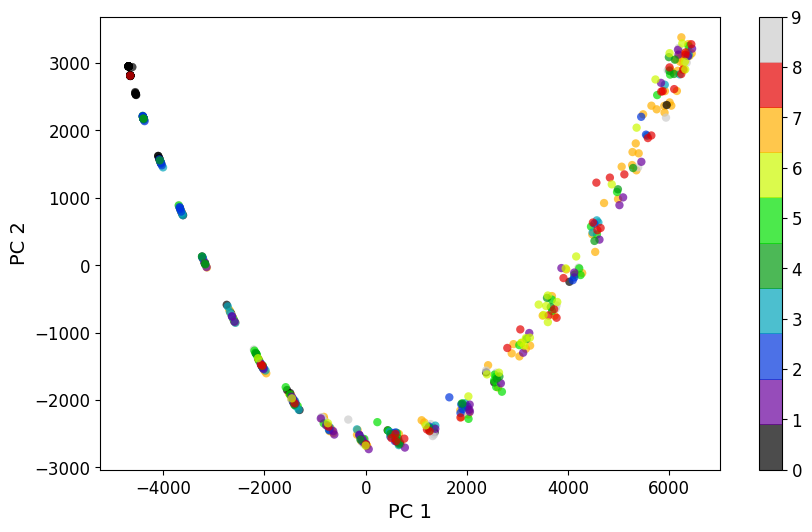

In [38]:
# PCA Plot 2D
projected = XX_silent
plt.scatter(projected[:, 0], projected[:, 1],c=YY_silent, edgecolor='none', alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar()
# save_fig("ICA_2D")
plt.show()

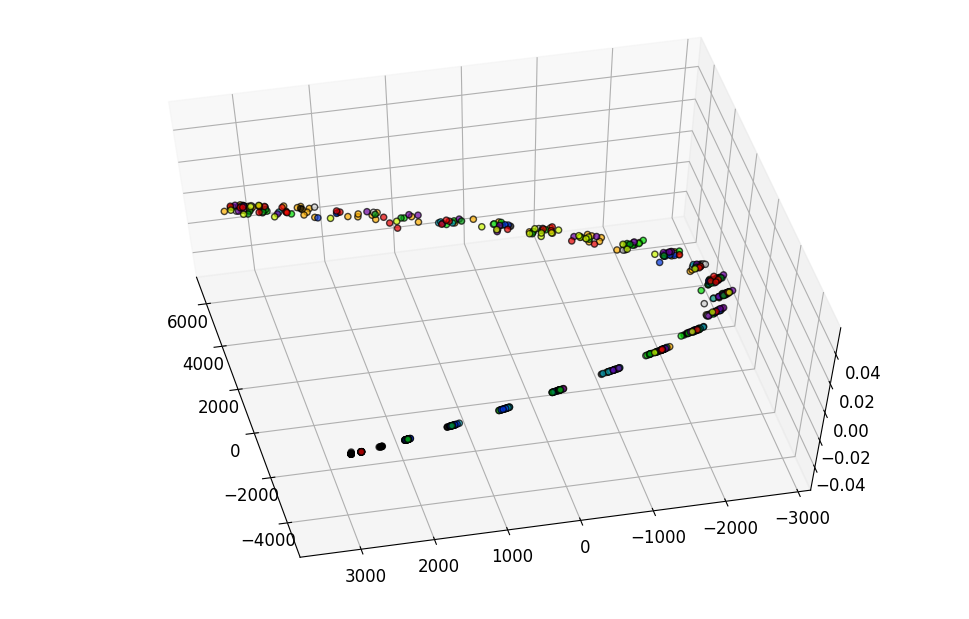

In [39]:
# PCA Plot 3D
fig = plt.figure()
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=60, azim=167)
ax.scatter(projected[:, 0], projected[:, 1],
            c=Y_silent, edgecolor='k', alpha=0.7,
            cmap=plt.cm.get_cmap("nipy_spectral", 10))

# save_fig("3Dpca")
plt.show()

### Train Test Split

In [40]:
def train_test_split(X_new,Y_new):
    split = StratifiedShuffleSplit(n_splits=1, test_size =0.1, random_state=42)
    train_id, test_id = next(split.split(X_new,Y_new))
    print("Train Set Shape: ",X_new[train_id].shape)
    print("Test Set Shape: ",X_new[test_id].shape)
    return X_new[train_id], Y_new[train_id], X_new[test_id], Y_new[test_id]

In [41]:
X_audible_train, Y_audible_train , X_audible_test, Y_audible_test = train_test_split(X_audible,Y_audible)
XX_audible_train, YY_audible_train , XX_audible_test, YY_audible_test = train_test_split(XX_audible,YY_audible)

Train Set Shape:  (1927, 200)
Test Set Shape:  (215, 200)
Train Set Shape:  (1927, 200)
Test Set Shape:  (215, 200)


In [42]:
X_whisper_train, Y_whisper_train , X_whisper_test, Y_whisper_test = train_test_split(X_whisper,Y_whisper)
XX_whisper_train, YY_whisper_train , XX_whisper_test, YY_whisper_test = train_test_split(XX_whisper,YY_whisper)

Train Set Shape:  (506, 200)
Test Set Shape:  (57, 200)
Train Set Shape:  (506, 200)
Test Set Shape:  (57, 200)


In [43]:
X_silent_train, Y_silent_train , X_silent_test, Y_silent_test = train_test_split(X_silent,Y_silent)
XX_silent_train, YY_silent_train , XX_silent_test, YY_silent_test = train_test_split(XX_silent,YY_silent)

Train Set Shape:  (504, 200)
Test Set Shape:  (57, 200)
Train Set Shape:  (504, 200)
Test Set Shape:  (57, 200)


## MACHINE LEARNING MODELS

In [70]:
def plotCM(y, predictions,y2,predictions2):
    cm = confusion_matrix(y, predictions)
#     print(cm)
#     plt.suptitle("KNN\n\n")
    plt.subplot(121)
    plt.title("With Temporal Features")
    plt.imshow(confusion_matrix(y, predictions,normalize="true"), interpolation = 'nearest',cmap = plt.cm.Reds)
    plt.xticks(range(len(LABELS)), LABELS, rotation = 45)
    plt.yticks(range(len(LABELS)), LABELS)
    
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

    for i in range(10):
        for j in range(10):
            plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
   

    plt.subplot(122)
    plt.title("With Spectral Features")
    plt.imshow(confusion_matrix(y2, predictions2,normalize="true"), interpolation = 'nearest',cmap = plt.cm.Reds)
    plt.xticks(range(len(LABELS)), LABELS, rotation = 45)
    plt.yticks(range(len(LABELS)), LABELS)
    
#     plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    cm = confusion_matrix(y2, predictions2)
    
    for i in range(10):
        for j in range(10):
            plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
#     save_fig("CNN_CM_DOUBLE-Silent")
    plt.show()

In [66]:
def KNN_Classifier(X_train,y_train,X_test,y_test,k=8):
    KNN_model = KNeighborsClassifier(n_neighbors=k, weights="uniform")
    KNN_model.fit(X_train,y_train)
    KNN_prediction = KNN_model.predict(X_train)
    KNN_accuracy = accuracy_score(y_train,KNN_prediction)
    return y_train,KNN_prediction


In [87]:
def MLP_Classifier(X_train,y_train,X_test,y_test):
    MLP_model = keras.Sequential()
    MLP_model.add(keras.layers.Dense(activation="relu",input_shape=X_train[0].shape,units=len(X_train[0])))
    MLP_model.add(keras.layers.Dense(64,activation="relu"))
    MLP_model.add(keras.layers.Dense(64,activation="relu"))
    MLP_model.add(keras.layers.Dense(10,activation="softmax"))
    print(MLP_model.summary())
#     loss = keras.losses.SparseCategoricalCrossentropy()
#     opt = keras.optimizers.Adam()
#     MLP_model.compile(optimizer=opt,loss=loss,metrics=["accuracy"])
#     history = MLP_model.fit(X_train,y_train,epochs=20,verbose=0,batch_size=50)
#     MLP_prediction = MLP_model.predict_classes(X_train)
#     MLP_accuracy = accuracy_score(y_train,MLP_prediction)
   
    
#     return y_train,MLP_prediction

In [89]:
def CNN_Classifier(X_train,y_train,X_test,y_test):
    
    y_train_temp = tf.keras.utils.to_categorical(y_train,num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)
    CNN_model = keras.Sequential()
    CNN_model.add(keras.layers.Conv1D(100,kernel_size=3,input_shape=(len(X_train[0]),1),activation="relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Conv1D(100,kernel_size=3,activation="relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Flatten())
    CNN_model.add(keras.layers.Dense(100,activation="relu"))
    CNN_model.add(keras.layers.Dense(10,activation="softmax"))

    print(CNN_model.summary())
#     loss = keras.losses.CategoricalCrossentropy()
#     opt = keras.optimizers.Adam()
#     CNN_model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

#     X_train = X_train.reshape(len(X_train),len(X_train[0]),1)
#     X_test = X_test.reshape(len(X_test),len(X_test[0]),1)
#     history = CNN_model.fit(X_train,y_train_temp,epochs=20,batch_size=50,verbose=0)
   
#     CNN_prediction = CNN_model.predict_classes(X_train)
#     CNN_accuracy = accuracy_score(y_train,CNN_prediction)
#     return y_train, CNN_prediction


## KNN CLASSIFIER

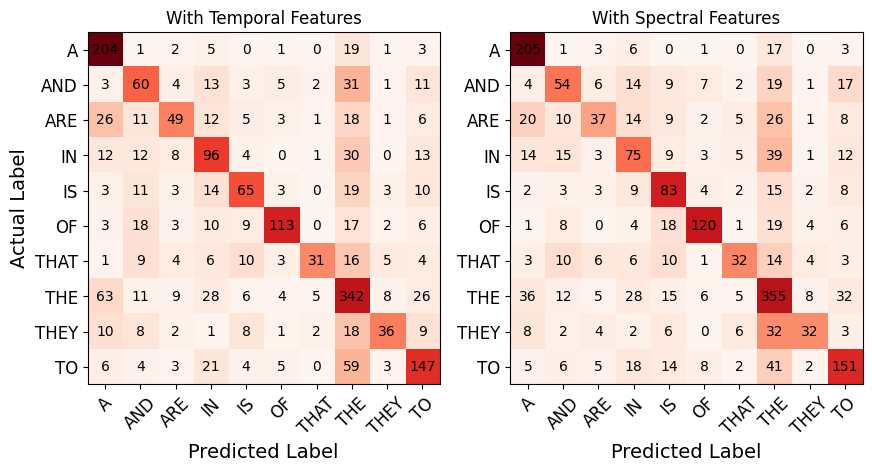

In [71]:
a,b = KNN_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)
c,d = KNN_Classifier(XX_audible_train,YY_audible_train,XX_audible_test,YY_audible_test)
plotCM(a,b,c,d)

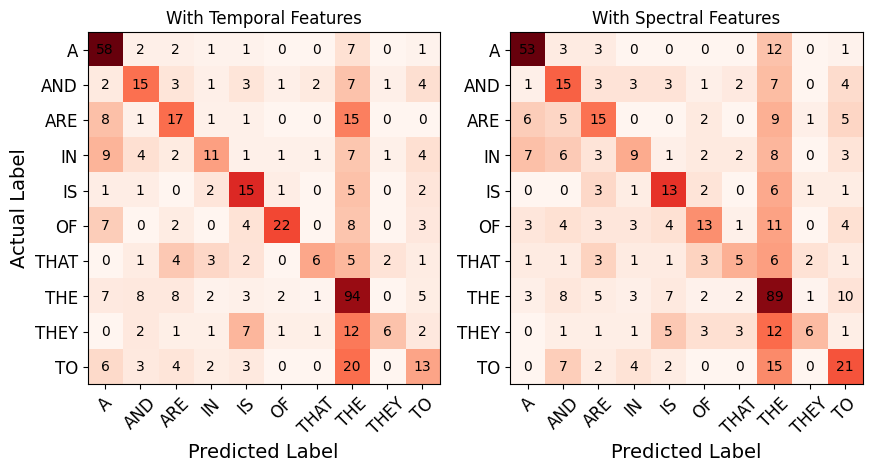

In [72]:
a,b = KNN_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test)
c,d = KNN_Classifier(XX_whisper_train,YY_whisper_train,XX_whisper_test,YY_whisper_test)
plotCM(a,b,c,d)

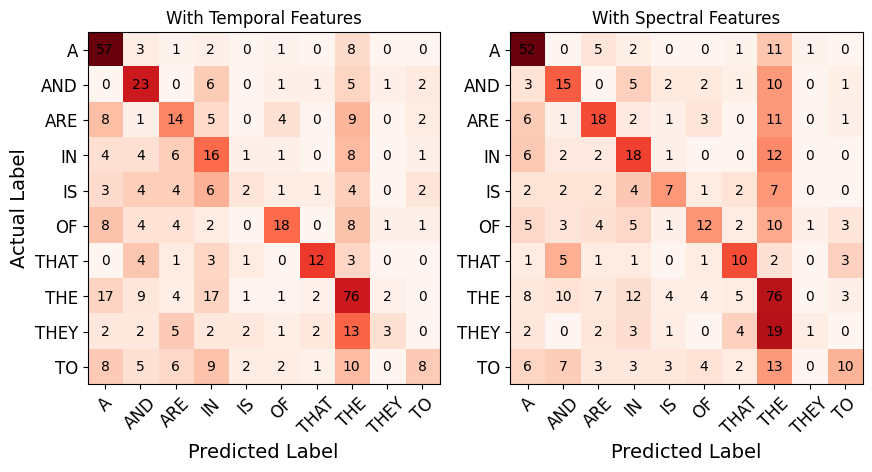

In [73]:
a,b = KNN_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test)
c,d = KNN_Classifier(XX_silent_train,YY_silent_train,XX_silent_test,YY_silent_test)
plotCM(a,b,c,d)

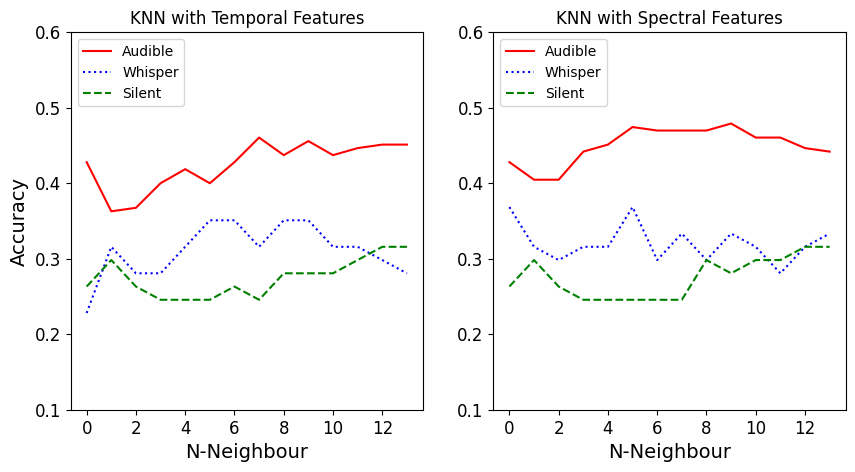

In [95]:
plt.subplot(121)
plt.title("KNN with Temporal Features")
plt.ylim([0.1,0.6])
plt.xticks(range(0,14,2))
plt.xlabel("N-Neighbour")
plt.ylabel("Accuracy")
plt.plot(a_acc,"r")
plt.plot(w_acc,"b:")
plt.plot(s_acc,"g--")
plt.legend(["Audible","Whisper","Silent"],loc="upper left")

plt.subplot(122)
plt.title("KNN with Spectral Features")
plt.ylim([0.1,0.6])
plt.xticks(range(0,14,2))

plt.xlabel("N-Neighbour")
plt.plot(aa_acc,"r")
plt.plot(ww_acc,"b:")
plt.plot(ss_acc,"g--")
plt.legend(["Audible","Whisper","Silent"],loc="upper left")

plt.savefig("KNN Accuracy(both)")
plt.show()


## MLP CLASSIFIER

In [88]:
MLP_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_41 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                650       
Total params: 57,874
Trainable params: 57,874
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


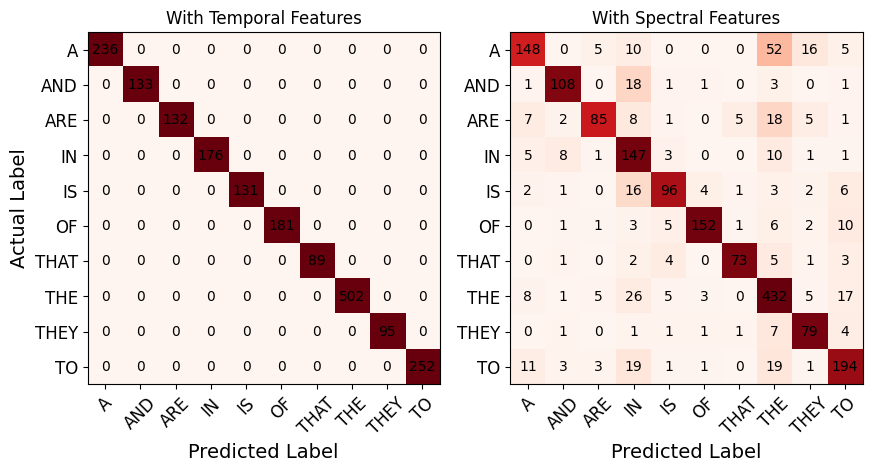

In [76]:
a,b = MLP_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)
c,d = MLP_Classifier(XX_audible_train,YY_audible_train,XX_audible_test,YY_audible_test)
plotCM(a,b,c,d)


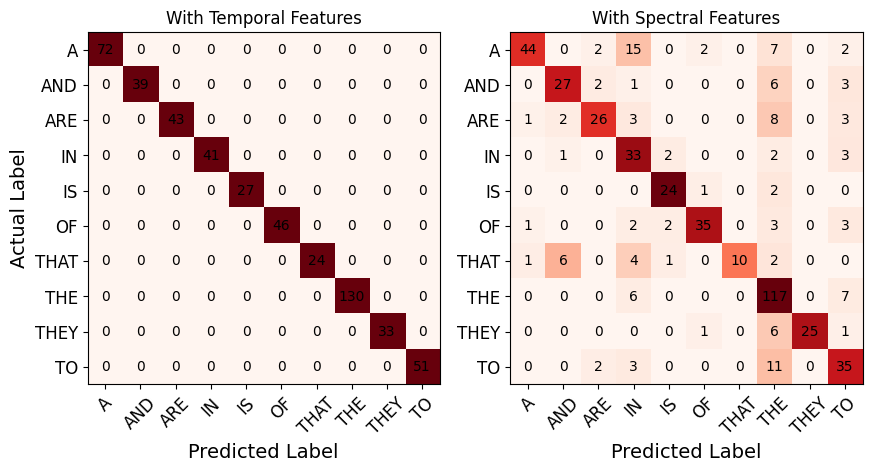

In [77]:
a,b = MLP_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test)
c,d = MLP_Classifier(XX_whisper_train,YY_whisper_train,XX_whisper_test,YY_whisper_test)
plotCM(a,b,c,d)

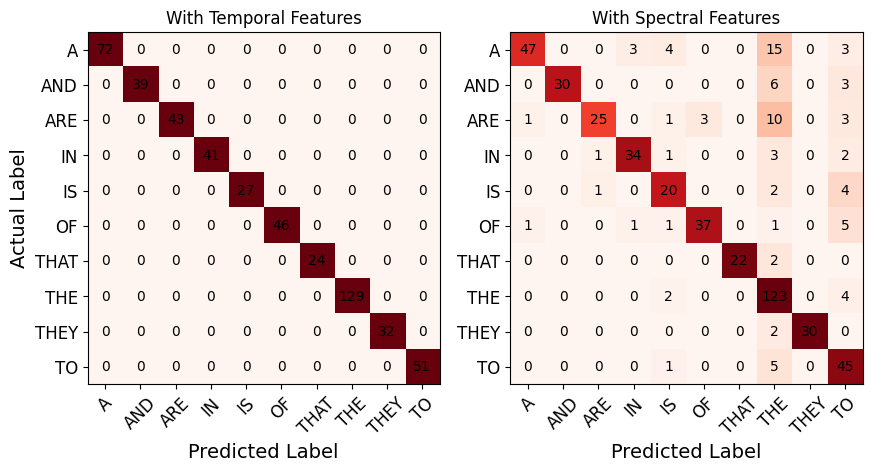

In [78]:
a,b = MLP_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test)
c,d = MLP_Classifier(XX_silent_train,YY_silent_train,XX_silent_test,YY_silent_test)
plotCM(a,b,c,d)

## CNN CLASSIFIER

In [90]:
CNN_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 198, 100)          400       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 99, 100)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 97, 100)           30100     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 48, 100)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               480100    
_________________________________________________________________
dense_45 (Dense)             (None, 10)              

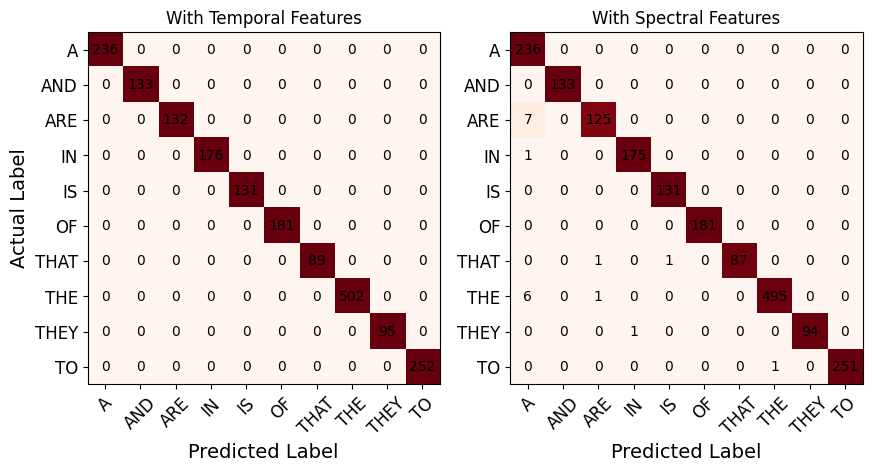

In [84]:
a,b = CNN_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)
c,d = CNN_Classifier(XX_audible_train,YY_audible_train,XX_audible_test,YY_audible_test)
plotCM(a,b,c,d)

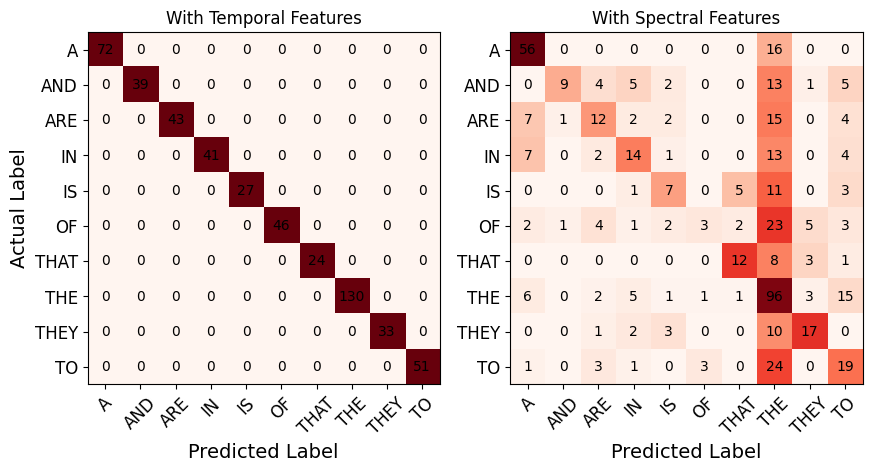

In [85]:
a,b = CNN_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test)
c,d = CNN_Classifier(XX_whisper_train,YY_whisper_train,XX_whisper_test,YY_whisper_test)
plotCM(a,b,c,d)

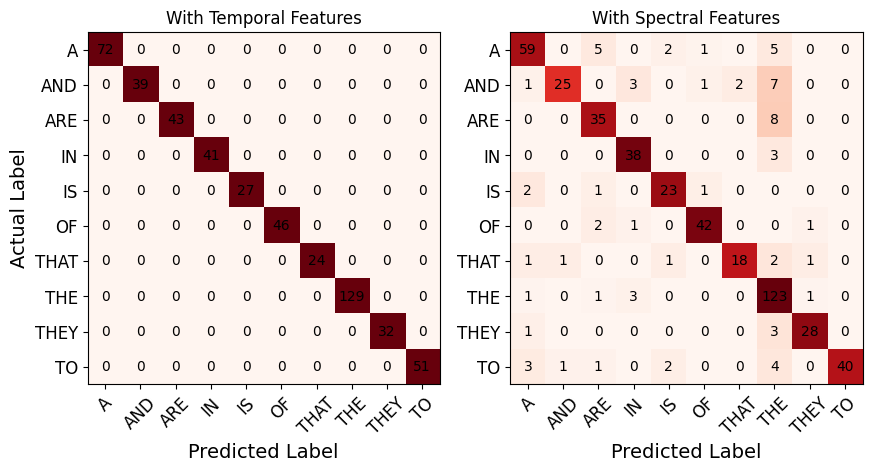

In [86]:
a,b = CNN_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test)
c,d = CNN_Classifier(XX_silent_train,YY_silent_train,XX_silent_test,YY_silent_test)
plotCM(a,b,c,d)

## TUNING MODEL PARAMETERS

### Tuning MLP Model

In [48]:
epochs = [20,50,100,200] #100 #200
batch_size = [20, 50, 70 , 80, 100, 150] #80 #50
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] #Adam
learn_rate = [0.000001, 0.00001, 0.00003, 0.0001, 0.0003, 0.003,0.03,0.3] #0.003
neurons = [64,100,150,200,300] #64
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#0.4 #0.2
activation = ["relu","sigmoid","tanh","linear"] #relu

# param_grid = dict(learn_rate=learn_rate)
# param_grid = dict(activation=activation)
# param_grid = dict(neurons=neurons,learn_rate=learn_rate,dropout_rate=dropout_rate)
# param_grid = dict(neurons=neurons)
# param_grid = dict(dropout_rate=dropout_rate,learn_rate=learn_rate)
# parameters = dict()

In [49]:
def MLP_model(dropout_rate=0.2,optimizer="adam",learn_rate=0.00003,activation="relu",neurons=64):
    model = keras.Sequential()
    model.add(keras.layers.Dense(input_shape=(200,),units=200,activation=activation))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(neurons,activation=activation))
    model.add(keras.layers.Dense(64,activation=activation))
    model.add(keras.layers.Dense(10,activation="softmax"))
    optimizer=keras.optimizers.Adam(lr=learn_rate)
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
#     print(model.summary())
    return model

In [279]:
clf = KerasClassifier(build_fn=MLP_model,verbose=0,epochs=100,batch_size=80)


In [280]:
gridCV = GridSearchCV(clf,param_grid=param_grid,n_jobs=1,cv=3)
grid_result = gridCV.fit(X_silent,Y_silent)

In [281]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.240642 using {'dropout_rate': 0.7, 'learn_rate': 0.0001}
0.000000 (0.000000) with: {'dropout_rate': 0.0, 'learn_rate': 1e-06}
0.114082 (0.062414) with: {'dropout_rate': 0.0, 'learn_rate': 1e-05}
0.155080 (0.054709) with: {'dropout_rate': 0.0, 'learn_rate': 3e-05}
0.183601 (0.048293) with: {'dropout_rate': 0.0, 'learn_rate': 0.0001}
0.190731 (0.045863) with: {'dropout_rate': 0.0, 'learn_rate': 0.0003}
0.201426 (0.053890) with: {'dropout_rate': 0.0, 'learn_rate': 0.003}
0.065954 (0.059602) with: {'dropout_rate': 0.0, 'learn_rate': 0.03}
0.048128 (0.068064) with: {'dropout_rate': 0.0, 'learn_rate': 0.3}
0.017825 (0.025209) with: {'dropout_rate': 0.1, 'learn_rate': 1e-06}
0.146168 (0.035561) with: {'dropout_rate': 0.1, 'learn_rate': 1e-05}
0.194296 (0.059281) with: {'dropout_rate': 0.1, 'learn_rate': 3e-05}
0.194296 (0.070989) with: {'dropout_rate': 0.1, 'learn_rate': 0.0001}
0.167558 (0.062108) with: {'dropout_rate': 0.1, 'learn_rate': 0.0003}
0.115865 (0.044812) with: {'dropout_r

In [825]:
def tuned_MLP_Classifier(dropout_rate=0.07,optimizer="adam",learn_rate=0.0001,activation="relu",neurons=64):
    model = keras.Sequential()
    model.add(keras.layers.Dense(input_shape=(200,),units=200,activation=activation))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(neurons,activation=activation))
#     model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(64,activation=activation))
    model.add(keras.layers.Dense(10,activation="softmax"))
    optimizer=keras.optimizers.Adam(lr=learn_rate)
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model
    

Model: "sequential_759"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3049 (Dense)           (None, 200)               40200     
_________________________________________________________________
dropout_808 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_3050 (Dense)           (None, 64)                12864     
_________________________________________________________________
dense_3051 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_3052 (Dense)           (None, 10)                650       
Total params: 57,874
Trainable params: 57,874
Non-trainable params: 0
_________________________________________________________________
None
[[ 46   0   3   3   0   1   1  14   0   4]
 [  2   5   0   0   1   2   2  25   1   1]
 [  6   0  12   4   1  

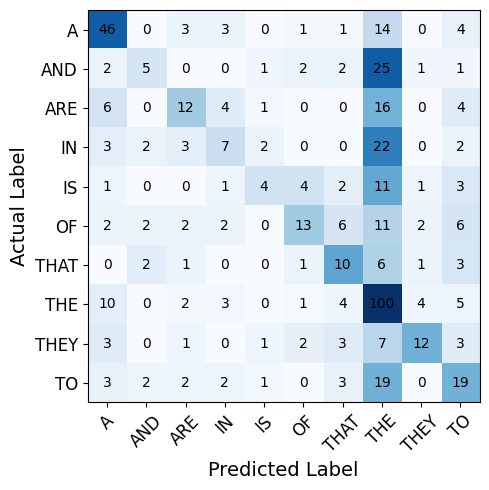

In [826]:
mlp = tuned_MLP_Classifier()
history = mlp.fit(X_silent_train,Y_silent_train,epochs=100,batch_size=80,verbose=0)
plotCM(Y_silent_train,mlp.predict_classes(X_silent_train))

In [827]:
print(max(history.history["accuracy"]))

0.3253968358039856


In [828]:
mlp.evaluate(X_silent_test,Y_silent_test)[1]

2/2 [==============================] - 0s 2ms/step - loss: 21.8304 - accuracy: 0.3158


0.31578946113586426

In [620]:
# def K_fold_CV(X_new,Y_new,K=10):
#     kfold = StratifiedKFold(n_splits=K,random_state=42)
#     acc = []
#     for train_id,test_id in kfold.split(X_new,Y_new):
# #         acc.append(KNN_Classifier(X_new[train_id],Y_new[train_id],X_new[test_id],Y_new[test_id]))
# #         acc.append(MLP_Classifier(X_new[train_id],Y_new[train_id],X_new[test_id],Y_new[test_id]))
# #         acc.append(CNN_Classifier(X_new[train_id],Y_new[train_id],X_new[test_id],Y_new[test_id]))
#     return np.array(acc)